In [1]:
import os
from dotenv import load_dotenv

load_dotenv()  # This loads the environment variables from the .env file

# Now you can access the variables like this:
openai_api_key = os.getenv("OPENAI_API_KEY")
antropic_api_key = os.getenv("ANTHROPIC_API_KEY")
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")

In [2]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")

In [3]:
from langchain_core.messages import AIMessage
from langchain_core.tools import tool

In [4]:
from craft_ai_sdk.io import Input, Output, InputSource, OutputDestination
from craft_ai_sdk import CraftAiSdk, INPUT_OUTPUT_TYPES, CREATION_PARAMETER_VALUE
from dotenv import load_dotenv
import craft_ai_sdk, os, json, time, requests

print (craft_ai_sdk.__version__)

load_dotenv()
stage = "integration" # integration , dave, kenny, preprod, prod

# Access the environment variables

craft_ai_environment_url = os.getenv("CRAFT_AI_ENVIRONMENT_URL_"+stage.upper())
craft_ai_sdk_token = os.getenv("CRAFT_AI_SDK_TOKEN_"+stage.upper())


if stage != "prod" :
    sdk = CraftAiSdk(environment_url=craft_ai_environment_url, sdk_token=craft_ai_sdk_token,control_url="https://"+stage+".craft.ai")
else : 
    sdk = CraftAiSdk(environment_url=craft_ai_environment_url, sdk_token=craft_ai_sdk_token)


stage = "preprod"
craft_ai_environment_url_preprod = os.getenv(f"CRAFT_AI_ENVIRONMENT_URL_{stage.upper()}")
craft_ai_sdk_token_preprod = os.getenv(f"CRAFT_AI_SDK_TOKEN_{stage.upper()}")

sdk_preprod = CraftAiSdk(
    environment_url=craft_ai_environment_url_preprod,
    sdk_token=craft_ai_sdk_token_preprod,
    control_url=f"https://{stage}.craft.ai"
)

0.49.0


In [63]:
import re
import uuid
from langchain_core.tools import StructuredTool

import random
import string
import json


def generate_random_characters(num_chars=10) -> str:
    characters = string.ascii_letters + string.digits  # Letters (uppercase and lowercase) + digits
    return ''.join(random.choice(characters) for _ in range(num_chars))

def divide(a: int, b :int):
    """Divide a and b"""
    return a/b


def multi(a: int, b :int):
    """Multiple a and b"""
    return a*b


def square_root(a: int):
    """square_root a"""

    res = sdk.trigger_endpoint(
        "product-square-root-depl",
        os.getenv("ENDPOINT_TOKEN_SQUARE_ROOT"),
        # Endpoint inputs: Commented inputs are optional, uncomment them to use them.
        inputs={
            "a": a,
        },
    )



    return res["outputs"]["b"]



def get_pipeline_info(pipeline_name:str):
    
    return sdk.get_pipeline(pipeline_name)


def get_user_name_info(user_id:str):
    return sdk.get_user(user_id)["name"]



def python_script_to_file(script:str):
    file_name = generate_random_characters()+".py"
    with open("steps/"+file_name, "w") as text_file:
        text_file.write(script)

    return file_name


""" def python_script_to_requirement(script:str):
    file_name = "requirements.py"
    with open(file_name, "w") as text_file:
        text_file.write(script)

    return file_name 
    """

def create_pipeline(pipeline_name, file_path, function_name):

    return sdk.create_pipeline(
        pipeline_name=pipeline_name,
        function_path=file_path,
        function_name=function_name,   
        container_config={
            "local_folder": "steps", 
            "requirements_path": CREATION_PARAMETER_VALUE.NULL
            
        },

    )
def run_pipeline(pipeline_name):


    return sdk.run_pipeline(pipeline_name=pipeline_name)

def get_execution_logs (execution_id):

    logs = sdk.get_pipeline_execution_logs(
        execution_id=execution_id
    )

    return '\n'.join(log["message"] for log in logs)

def prediction_RTE(region):
    """prediction_RTE region"""

    response =  sdk_preprod.trigger_endpoint(
        "rte-predict-xgb-endpt",
        os.getenv("ENDPOINT_TOKEN_RTE_XGB"),
        inputs={
            "focal_location": region,  
        },
    )

    predictions_byte = response['outputs']['predictions']
    decoded_predictions = predictions_byte.decode('utf-8')

    # predictions_list = json.loads(decoded_predictions)


    return decoded_predictions


tool_registry = {
    str(uuid.uuid4()): StructuredTool.from_function(divide,
        name="devide_number",
        description=f"Take 2 int give as parameter and divide number1/number2 as return",
    ),
    str(uuid.uuid4()): StructuredTool.from_function(multi,
        name="multiple_number",
        description=f"Take 2 int give as parameter and multiple number1*number2 as return",
    ),
    str(uuid.uuid4()): StructuredTool.from_function(square_root,
        name="square_root",
        description=f"Take 1 int give as parameter and do a square root of it as return",
    ),
    str(uuid.uuid4()): StructuredTool.from_function(get_pipeline_info,
        name="get_pipeline_info",
        description=f"Take pipeline name as input to give in return object with all pipeline info",
    ),
    str(uuid.uuid4()): StructuredTool.from_function(get_user_name_info,
        name="get_user_name_info",
        description=f"Take user as input to give in return user name",
    ),
    str(uuid.uuid4()): StructuredTool.from_function(python_script_to_file,
        name="python_script_to_file",
        description=f"Take script python as input to put it in file to prepare pipeline creation after",
    ),
    str(uuid.uuid4()): StructuredTool.from_function(create_pipeline,
        name="create_pipeline",
        description=f"Take pipeline_name, file_path, function_name as input and create pipeline with it",
    ),
    str(uuid.uuid4()): StructuredTool.from_function(run_pipeline,
        name="run_pipeline",
        description=f"Take pipeline_name as input and run the given pipeline",
    ),
    str(uuid.uuid4()): StructuredTool.from_function(get_execution_logs,
        name="get_execution_logs",
        description=f"Take execution_id as input and give back execution logs",
    ),
    str(uuid.uuid4()): StructuredTool.from_function(prediction_RTE,
        name="prediction_RTE",
        description=f"Take region as input and make electrical consumption prediction for the next mounth",
    ),
}

In [64]:
from langchain_core.documents import Document
from langchain_core.vectorstores import InMemoryVectorStore, VectorStore
from langchain_openai import OpenAIEmbeddings

tool_documents = [
    Document(
        page_content=tool.description,
        id=id,
        metadata={"tool_name": tool.name},
    )
    for id, tool in tool_registry.items()
]

vector_store = InMemoryVectorStore(embedding=OpenAIEmbeddings())
document_ids = vector_store.add_documents(tool_documents)

In [65]:
from typing import Literal
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from langgraph.graph import StateGraph, MessagesState
from langgraph.prebuilt import ToolNode


# llm = ChatAnthropic(
#     model="claude-3-haiku-20240307", temperature=0
# ).bind_tools(tools)

tools = list(tool_registry.values())
llm = ChatOpenAI()

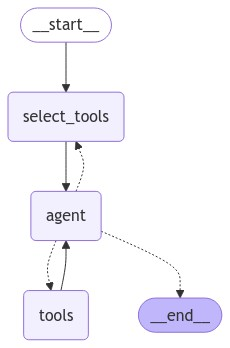

In [66]:
from typing import Literal
from langchain_core.vectorstores import InMemoryVectorStore, VectorStore
from langchain_openai import OpenAIEmbeddings
from langgraph.graph import StateGraph, MessagesState
from typing import Annotated
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from langgraph.prebuilt import ToolNode, tools_condition


def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return "__end__"

class State(TypedDict):
    messages: Annotated[list, add_messages]
    selected_tools: list[str]


def agent(state: State):
    selected_tools = [tool_registry[id] for id in state["selected_tools"]]
    llm_with_tools = llm.bind_tools(selected_tools)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

def select_tools(state: State):
    last_user_message = state["messages"][-1]
    query = last_user_message.content
    tool_documents = vector_store.similarity_search(query)
    # print (tool_documents)
    return {"selected_tools": [document.id for document in tool_documents]}


workflow = StateGraph(MessagesState)
# Define the two nodes we will cycle between
workflow.add_node("agent", agent)
tool_node = ToolNode(tools=tools)
workflow.add_node("tools", tool_node)

workflow.add_conditional_edges(
    "agent",
    tools_condition,
)
workflow.add_node("select_tools", select_tools)

workflow.add_edge("__start__", "select_tools")
workflow.add_edge("select_tools", "agent")
workflow.add_edge("tools", "agent")
# workflow.add_edge("agent", "tools")

app = workflow.compile()
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [67]:
prompt= "Tell me a story in 20 words" 


# example with a single tool call
for chunk in app.stream(
    {"messages": [("human", prompt)]}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Tell me a story in 20 words
================================ Human Message =================================

Tell me a story in 20 words
================================== Ai Message ==================================

Once upon a time, in a magical forest, a brave squirrel found a treasure and shared it with friends. The end.


In [10]:
from langchain_core.messages import AIMessageChunk, HumanMessage

inputs = [HumanMessage(content="what is the weather in sf")]
first = True
async for msg, metadata in app.astream({"messages": inputs}, stream_mode="messages"):
    if msg.content and not isinstance(msg,HumanMessage):
        print(msg.content, end="|", flush=True)

    if isinstance(msg, AIMessageChunk):
        if first:
            gathered = msg
            first = False
        else:
            gathered = gathered + msg

        if msg.tool_call_chunks:
            print(gathered.tool_calls)

In [70]:
inputs = {"messages": [("human", "Tell me a story in 50 words")]}
async for event in app.astream_events(inputs, version="v2"):
    kind = event["event"]
    tags = event.get("tags", [])
    # filter on the custom tag
    if kind == "on_chat_model_stream" : # and "final_node" in event.get("tags", [])
        data = event["data"]
        if data["chunk"].content:
            # Empty content in the context of OpenAI or Anthropic usually means
            # that the model is asking for a tool to be invoked.
            # So we only print non-empty content
            print(data["chunk"].content, end="", flush=True)

Once upon a time, in a magical forest, a curious squirrel named Sam embarked on a quest to find the legendary acorn of wisdom. Along the way, Sam encountered friendly animals, solved puzzles, and faced challenges. In the end, Sam discovered that true wisdom comes from within. And they all lived happily ever after.

In [82]:
from openai import OpenAI

# init client and connect to localhost server
client = OpenAI(
    api_key="fake-api-key",
    base_url="http://127.0.0.1:8001" # change the default port if needed
)

# call API
chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": "Give me logs of hello-agent-6",
        }
    ],
    model="gpt-4o-mini",
)

print(chat_completion.choices[0].message.content)

I encountered an error while trying to retrieve the logs for the execution "hello-agent-6". It seems that the resource does not exist. Please double-check the execution ID and try again.


In [88]:
from openai import OpenAI


client = OpenAI(
    api_key="fake-api-key",
    base_url="http://localhost:8001" # change the default port if needed
)

# Function to stream the response
def get_streaming_response(prompt):

    # Create the chat completion with streaming enabled
    response = client.chat.completions.create(
        model="gpt-4o-mini",  # Use the appropriate model
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt},
        ],
        stream=True  # Enable streaming
    )



    for chunk in response:

        
        print(chunk.choices[0].delta.content, end="")


# Call the function to get the streaming response
get_streaming_response("tell me a story in 50 words")

I 
 will 
 craft 
 a 
 story 
 for 
 you 
, 
 but 
 I 
 will 
 need 
 to 
 use 
 multiple 
 tools 
 to 
 help 
 me 
 along 
 the 
 way 
. 
 Let 
's 
 start 
 by 
 running 
 a 
 pipeline 
 to 
 generate 
 a 
 story 
 and 
 then 
 I 
 will 
 narr 
ate 
 it 
 to 
 you 
. 
It 
 seems 
 there 
 was 
 an 
 error 
 in 
 running 
 the 
 pipeline 
 to 
 generate 
 a 
 story 
. 
 Let 
 me 
 try 
 a 
 different 
 approach 
. 
 I 
 will 
 now 
 proceed 
 to 
 create 
 a 
 story 
 for 
 you 
 using 
 a 
 combination 
 of 
 tools 
. 
 Let 
's 
 begin 
 by 
 writing 
 the 
 story 
 script 
 in 
 Python 
. 
The 
 Python 
 script 
 for 
 the 
 story 
 has 
 been 
 successfully 
 saved 
. 
 Now 
, 
 let 
 me 
 retrieve 
 the 
 content 
 of 
 the 
 story 
 and 
 narr 
ate 
 it 
 to 
 you 
. 
I 
 encountered 
 an 
 error 
 while 
 trying 
 to 
 retrieve 
 and 
 narr 
ate 
 the 
 story 
 script 
. 
 Let 
 me 
 correct 
 this 
. 
 I 
 will 
 read 
 the 
 Python 
 script 
 directly 
 and 
 narr 
ate 
 the 
 